In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_power = pd.read_csv("./data/power_usage_2016_to_2020.csv")
df_weather = pd.read_csv("./data/weather_2016_2020_daily.csv")

In [3]:
df_power["StartDate"] = pd.to_datetime(df_power.StartDate)
df_weather["Date"] = pd.to_datetime(df_weather.Date)

In [4]:
df_power.index = df_power["StartDate"]
df_weather.index = df_weather["Date"]

In [5]:
drop_weather = ['Date']
df_weather.drop(columns=drop_weather, inplace=True)

In [6]:
drop_power = ["StartDate", "day_of_week"]
df_power.drop(columns=drop_power, inplace=True)

In [7]:
rename_power = {"Value (kWh)": "kWh", "notes": "type_of_day"}
df_power.rename(columns=rename_power, inplace=True)

In [8]:
df_power.head()

,kWh,type_of_day
StartDate,,
2016-01-06 00:00:00,1.057,weekday
2016-01-06 01:00:00,1.171,weekday
2016-01-06 02:00:00,0.560,weekday
2016-01-06 03:00:00,0.828,weekday
2016-01-06 04:00:00,0.932,weekday


In [9]:
df_power = df_power.resample("D").sum()

In [10]:
df_power.head()

,kWh
StartDate,
2016-01-06,29.691
2016-01-07,43.177
2016-01-08,50.057
2016-01-09,47.363
2016-01-10,42.203


In [11]:
df_power.shape

(1797, 1)

In [12]:
df_weather.head()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
Date,,,,,,,,,,,,,,,,,,
2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [13]:
df_weather.shape

(1552, 18)

In [14]:
df = df_power.merge(df_weather, left_index=True, right_index=True)
df.head()

,kWh,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
2016-01-06,29.691,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-01-07,43.177,1,94,84.9,76,76,74.0,72,94,71.6,51,13,5.7,0,29.9,29.9,29.8,0.00,3
2016-01-08,50.057,1,97,86.5,75,76,73.3,67,96,67.3,37,20,6.0,0,30.0,29.9,29.9,0.00,4
2016-01-09,47.363,1,96,86.2,78,75,73.3,70,88,67.1,46,13,6.3,0,29.8,29.8,29.7,0.01,5
2016-01-10,42.203,1,81,71.1,61,64,59.4,57,90,68.7,45,8,3.3,0,30.0,29.9,29.9,0.00,6


In [15]:
df.shape

(1550, 19)

# EDA Visualizations

<AxesSubplot:>

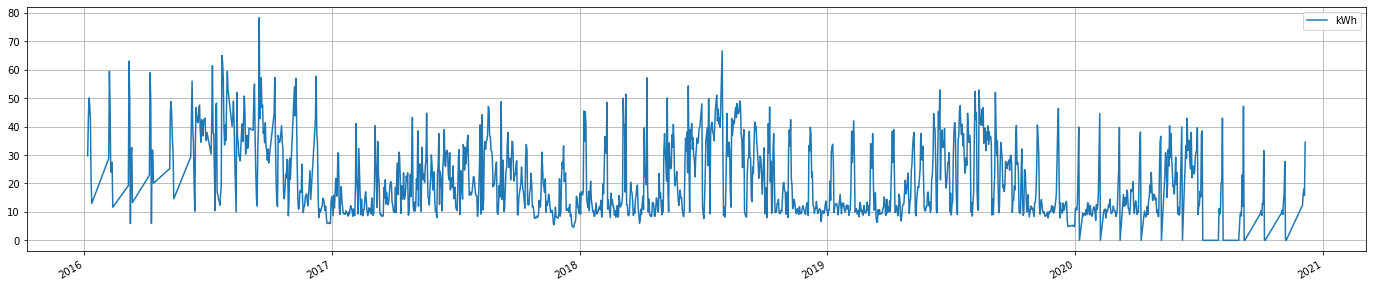

In [25]:
df.kWh.plot(figsize=(24,5), grid=True, legend=True)
plt.xlabel

<AxesSubplot:>

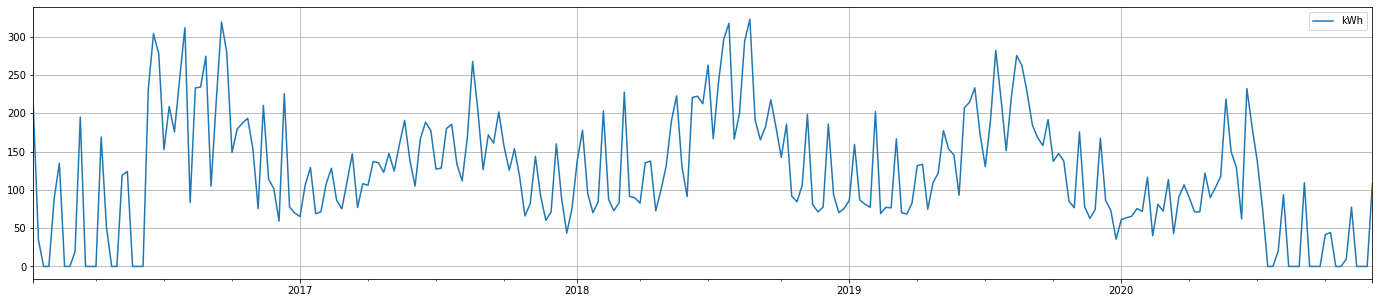

In [28]:
df["kWh"].resample("W").sum().plot(figsize=(24, 5), grid=True, legend=True)

<AxesSubplot:>

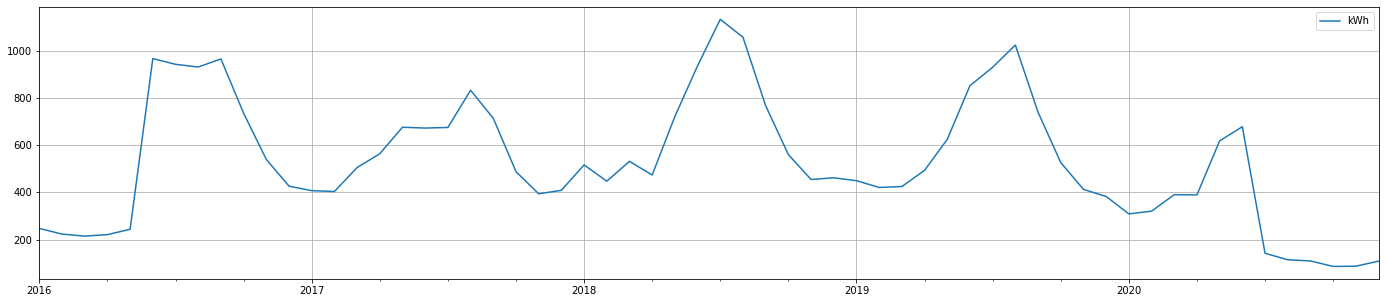

In [29]:
df["kWh"].resample("M").sum().plot(figsize=(24,5), grid=True, legend=True)

# Correlation Heat Map